In [1]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

from tqdm.auto import tqdm
tqdm.pandas()

%matplotlib inline

In [2]:
wb = load_workbook('20211124_compiled_data.xlsx')
sheetnames = wb.sheetnames

In [3]:
def parse_time(time_str):
    try:
        return float(time_str)
    except TypeError:
        return pd.to_timedelta(str(time_str)).total_seconds() / 60


data = []
for i, sheet in enumerate(sheetnames):
    df = pd.read_excel(
        '20211124_compiled_data.xlsx', sheet_name=sheet, 
        converters={'Time(hh:mm:ss)': parse_time})\
        .set_index('Time(hh:mm:ss)').unstack().reset_index()
    df['cofactor'] = 'NADP' if 'NADP' in sheet else 'NAD'
    df.columns = ['mutation', 'time_s', 'value', 'cofactor']
    df['run'] = i
    data += [df]
    
data = pd.concat(data).dropna().reset_index(drop=True)

In [4]:
# Clip data after the maximum value is seen
data = data.groupby(['cofactor', 'mutation', 'run']).apply(
    lambda df: df.loc[:df.value.idxmax()]).reset_index(drop=True)

In [5]:
# # I don't think I have any NADP / WT data in this spreadsheet?
data = data.drop(data[(data.cofactor == 'NAD') & data.mutation.str.startswith('WT')].index)
# data.loc[data[(data.cofactor == 'NAD') & data.mutation.str.startswith('WT')].index, 'cofactor'] = 'NADP'

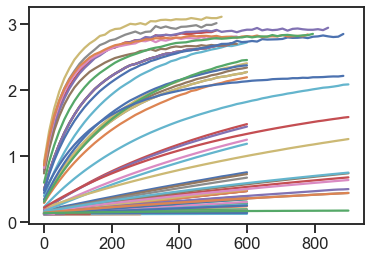

In [6]:
for _, df in data[data.cofactor == 'NAD'].groupby(['mutation', 'run']):
    plt.plot(df.time_s, df.value)

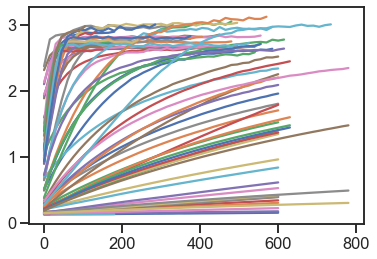

In [7]:
for _, df in data[data.cofactor == 'NADP'].groupby(['mutation', 'run']):
    plt.plot(df.time_s, df.value)

In [8]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

In [9]:
def f(t, y, v_max, k_m):
    return -v_max * y / (k_m + y)

def g(p, df, residual=True):
    y0 = p[0]  # initial concentration of NAD[P]+
    t_offset = p[1]  # time offset
    x0 = p[2]  # initial [NAD[P]H]

    # solve for NAD[P]+ -> 0
    out = solve_ivp(f, (0, df.time_s.max() + t_offset), np.array([y0]), args=(p[3], p[4]),
                    t_eval=df.time_s + t_offset, vectorized=True)
    
    # Conversion of NAD[P]H
    x = (y0 - out.y[0]) + x0
    
    if residual:
        return df.value - x
    
    else:
        return x

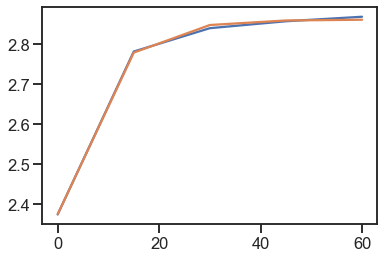

In [10]:
bounds = [(2.0, 0, 0, 0, .1), (3.1, 15, .2, np.inf, 10)]  # max 15-seconds before t0 measurement?
bounds_ext = [(2.0, 0, 0, 0, .1), (3.1, 45, .2, np.inf, 10)]

x0 = [3, 10, .1, .01, .5]

# df = data[(data.cofactor == 'NADP') & (data.mutation == 'SM083')]
# df = data[(data.cofactor == 'NADP') & (data.mutation == 'SM129')]
# df = data[(data.mutation == 'SM091') & (data.cofactor == 'NAD')]
# df = data[(data.cofactor == 'NAD') & (data.mutation == 'SM038') & (data.run == 2)]
df = data[(data.cofactor == 'NADP') & (data.mutation == 'SM091')]
opt = least_squares(g, x0, bounds=bounds_ext, args=(df,))

plt.plot(df.time_s, df.value)
plt.plot(df.time_s, g(opt.x, df, residual=False))

In [11]:
def fit(df):
    opt = least_squares(g, x0, bounds=bounds, args=(df,))
    if (opt.fun ** 2).sum() > 0.25:
        opt = least_squares(g, x0, bounds=bounds_ext, args=(df,))
    
    return pd.Series((*opt.x, (opt.fun ** 2).sum()), index=['y0', 't_offset', 'x0', 'v_max', 'k_m', 'loss'])

In [12]:
fit_results = data.groupby(['cofactor', 'mutation', 'run']).progress_apply(fit)

  0%|          | 0/155 [00:00<?, ?it/s]

In [13]:
fit_results.loss.sort_values().tail()

cofactor  mutation  run
NAD       SM130     6      0.164093
          SM128     6      0.167679
          SM125     8      0.177522
NADP      SM090     0      0.201154
NAD       SM122     6      0.207742
Name: loss, dtype: float64

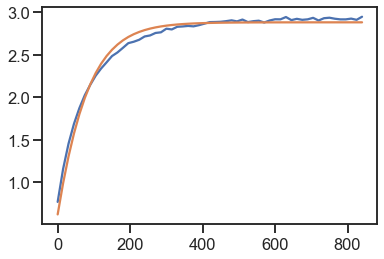

In [14]:
df = data[(data.cofactor == 'NAD') & (data.mutation == 'SM122')]
opt = least_squares(g, x0, bounds=bounds, args=(df,))

plt.plot(df.time_s, df.value)
plt.plot(df.time_s, g(opt.x, df, residual=False))

In [15]:
results = fit_results.reset_index()
# results['mutation'] = results.mutation.str.replace('\.\d', '', regex=True)
results['efficiency'] = results['v_max'] / results['k_m']

In [16]:
results.sort_values('efficiency')

,cofactor,mutation,run,y0,t_offset,x0,v_max,k_m,loss,efficiency
33,NAD,SM102,2,2.000885,14.324883,0.124259,0.000009,9.991517,1.718863e-07,8.596106e-07
31,NAD,SM100,2,2.000760,13.390647,0.162200,0.000010,9.645951,1.962440e-07,9.906471e-07
36,NAD,SM105,2,2.006060,0.087185,0.128289,0.000022,9.860904,2.401672e-10,2.209383e-06
30,NAD,SM099,2,2.000330,14.998263,0.138885,0.000031,9.975639,7.979718e-07,3.093800e-06
11,NAD,SM084,3,2.003308,14.492490,0.119837,0.000034,9.968079,4.070111e-07,3.385043e-06
...,...,...,...,...,...,...,...,...,...,...
150,NADP,WT.1,5,2.553783,15.000000,0.200000,0.059848,0.404177,3.372649e-03,1.480729e-01
151,NADP,WT.1,7,2.553783,15.000000,0.200000,0.059848,0.404177,3.372649e-03,1.480729e-01
152,NADP,WT.1,9,2.553783,15.000000,0.200000,0.059848,0.404177,3.372649e-03,1.480729e-01
154,NADP,WT.3,1,2.606231,15.000000,0.200000,0.055400,0.359013,3.464497e-03,1.543132e-01


In [17]:
orig_data = pd.read_csv('https://github.com/jlaw9/fairseq-uniparc/raw/esm_fairseq/cofactor_translation/gapn/20211018-GapN-data-up-to-SM160.csv', index_col=0)

In [18]:
nad_results = results.groupby(['cofactor', 'mutation']).mean().loc['NAD']
nadp_results = results.groupby(['cofactor', 'mutation']).mean().loc['NADP']

In [19]:
orig_data.index = orig_data.index.str.strip('p')

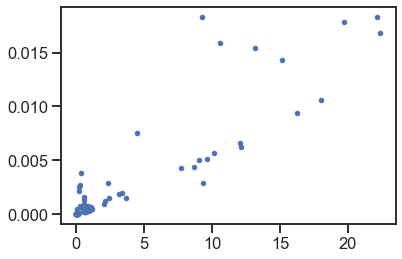

In [20]:
plt.plot(orig_data['NAD+_initial_rate'].reindex(nad_results.index), nad_results.efficiency, '.')

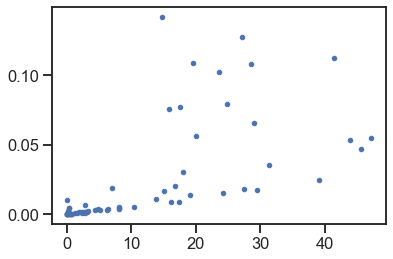

In [21]:
plt.plot(orig_data['NADP+_initial_rate'].reindex(nadp_results.index), nadp_results.efficiency, '.')

In [22]:
cm = plt.get_cmap('viridis')

In [24]:
nadp_results['xform_efficiency'] = np.log(nadp_results.efficiency).transform(lambda x: (x - x.min()) / (x.max() - x.min()))
nad_results['xform_efficiency'] = np.log(nad_results.efficiency).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [25]:
# nadp_orig = np.log(orig_data['NADP+_initial_rate'].clip(lower=1E-4)).transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# nad_orig = np.log(orig_data['NAD+_initial_rate'].clip(lower=1E-4)).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

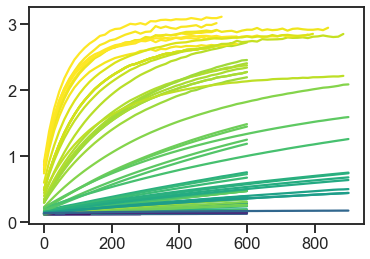

In [26]:
for (mutation, run), df in data[data.cofactor == 'NAD'].groupby(['mutation', 'run']):
    plt.plot(df.time_s, df.value, color = cm(nad_results.loc[mutation, 'xform_efficiency']))

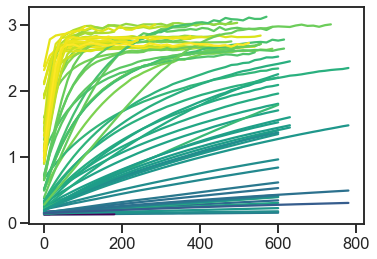

In [27]:
for (mutation, run), df in data[data.cofactor == 'NADP'].groupby(['mutation', 'run']):
    plt.plot(df.time_s, df.value, color = cm(nadp_results.loc[mutation, 'xform_efficiency']))

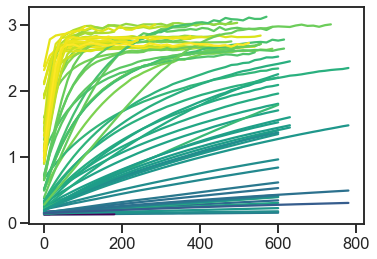

In [28]:
for (mutation, run), df in data[data.cofactor == 'NADP'].groupby(['mutation', 'run']):
    plt.plot(df.time_s, df.value, color = cm(nadp_results.loc[mutation, 'xform_efficiency']))

In [29]:
results = results.drop(results[results.mutation == 'WT NADP'].index)
results['mutation'] = results.mutation.str.replace('\.\d', '', regex=True)
mean_results = results.groupby(['cofactor', 'mutation']).mean()

In [30]:
nad = mean_results.loc['NAD']
nadp = mean_results.loc['NADP'].reindex(nad.index)

Text(0, 0.5, 'NADP Efficiency')

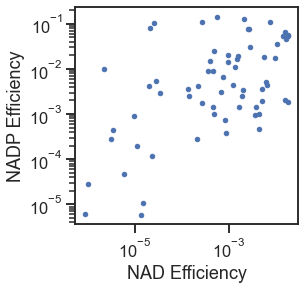

In [31]:
plt.figure(figsize=(4,4))
plt.loglog(nad.efficiency, nadp.efficiency, '.')
plt.xlabel('NAD Efficiency')
plt.ylabel('NADP Efficiency')

In [32]:
unstacked_results = mean_results.efficiency.unstack().T
unstacked_results

cofactor,NAD,NADP
mutation,,
SM038,0.000482,0.024694
SM074,0.000490,0.001022
SM075,0.000011,0.000201
SM078,0.000025,0.102026
SM079,0.000021,0.079691
...,...,...
SM147,0.006657,0.004389
SM148,0.000210,0.000282
SM149,0.000023,0.000121


In [33]:
unstacked_results.to_csv('20211214_estimated_kinetics.csv')